In [1]:
import cv2
import yaml
import numpy as np
from PIL import Image as PImage
from detection.utils.bbox import format_yolov5
from detection.utils.image import drawBox


# 1. Data Exploration

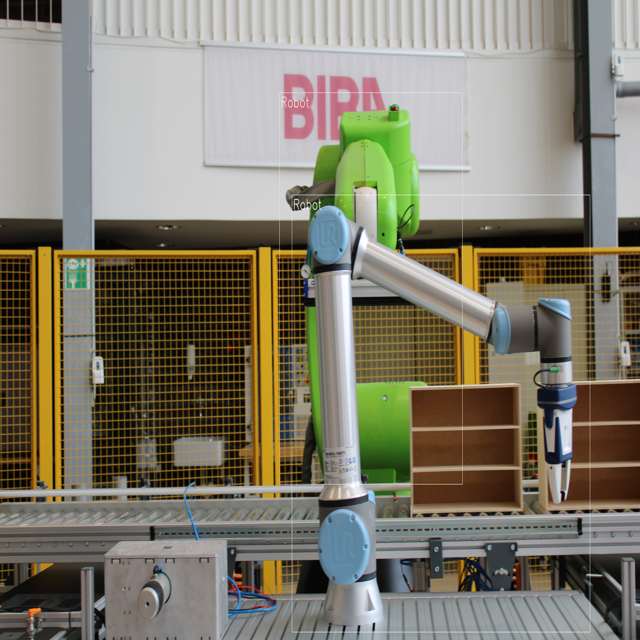

In [2]:
data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=yaml.SafeLoader)
img = np.array(PImage.open("detection/dataset/machine/images/IMG_0197.JPG"))
targets = np.genfromtxt("detection/dataset/machine/whole/labels/IMG_0197.txt", delimiter=" ")
targets = format_yolov5(targets, img)

img_anno = PImage.fromarray(drawBox(img, targets, data["names"], targets_type="rel:pascal_voc"))
display(img_anno.resize((640, 640)))

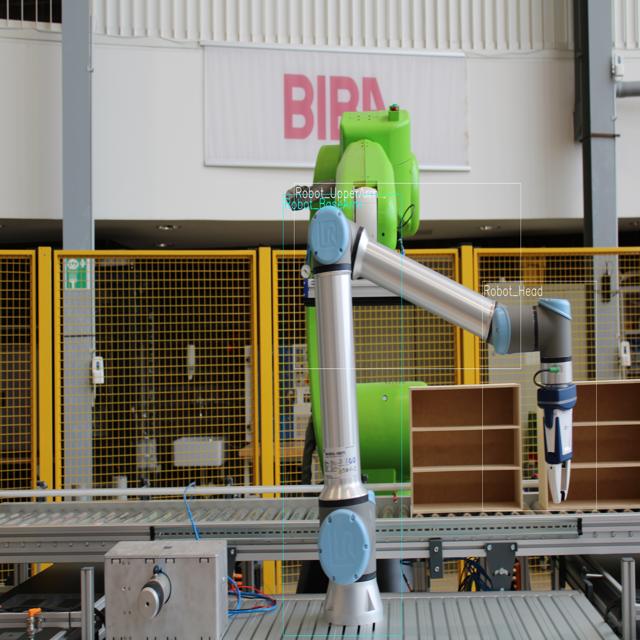

In [3]:
data = yaml.load(open("detection/dataset/data.yaml"), Loader=yaml.SafeLoader)
img = np.array(PImage.open("detection/dataset/machine/images/IMG_0197.JPG"))
targets = np.genfromtxt("detection/dataset/machine/parts/labels/IMG_0197.txt", delimiter=" ")
targets = format_yolov5(targets, img)

img_anno = PImage.fromarray(drawBox(img, targets, data["names"], targets_type="rel:pascal_voc"))
display(img_anno.resize((640, 640)))

# 2. Preprocessing

## 2.1 Import labels

In [4]:
from detection.utils.dataset import readLabel_yolo
import yaml

data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=yaml.SafeLoader)
class_names = data["names"]
df_label = readLabel_yolo(label_dir="detection/dataset/machine/whole/labels", class_names=class_names)
df_label.sample(5)

,filename,x,y,w,h,cat
552,IMG_0420,0.307031,0.537500,0.230469,0.700000,6
97,IMG_0239,0.614844,0.542188,0.392969,0.824219,6
195,IMG_0274,0.902344,0.242969,0.061719,0.090625,5
313,IMG_0327,0.555469,0.538281,0.307031,0.813281,6
467,IMG_0391,0.706250,0.573438,0.200781,0.242188,5


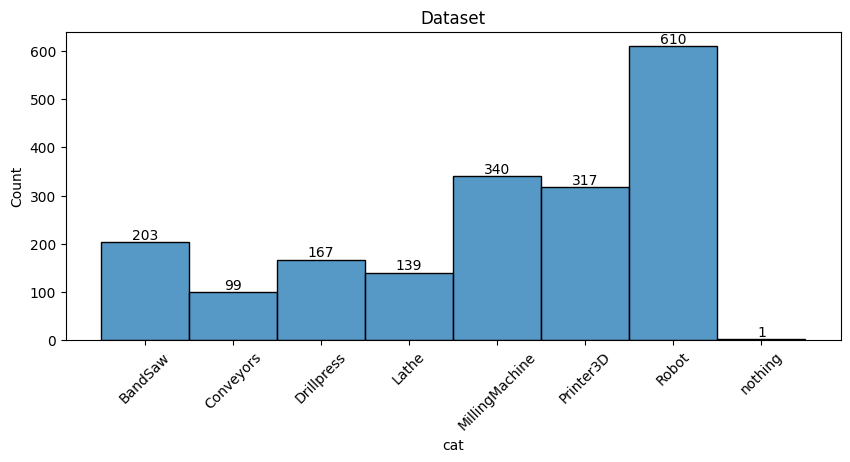

In [5]:
from detection.utils.plot import plothist
import matplotlib.pyplot as plt

fig, axe = plt.subplots(figsize=(10, 4))
plothist(axe, df_label["cat"], class_names + ["nothing"], title="Dataset")
plt.show()

## 2.2 Generate each class using augmentation 

In [8]:
from detection.utils.dataset import Dataset

dataset_ = Dataset(
    data_path="detection/dataset/data_whole.yaml",
    image_dir="detection/dataset/machine/images",
    label_dir="detection/dataset/machine/whole/labels",
    saved_dir="detection/dataset/machine_preprocessed/whole",
    resize=(640, 640),)

In [9]:
dataset_.copy_org()

100%|██████████| 873/873 [07:20<00:00,  1.98it/s]


In [10]:
dataset_.balance_class(limit=700)

  4%|▍         | 155/3729 [02:49<3:26:20,  3.46s/it]

In [ ]:
df_label = readLabel_yolo(label_dir="detection/dataset/machine_preprocessed/whole/labels", class_names=class_names)
df_label.sample(5)

In [ ]:
from detection.utils.plot import plothist

data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=SafeLoader)
cat_names = data["names"] + ["nothing"]
fig, axe = plt.subplots(figsize=(10, 4))
plothist(axe, df_label["cat"], cat_names, title="Dataset")
plt.show()

## 2.3 Split dataset

In [ ]:
split_dataset = dataset_.split(0.2, 0.1, "detection/dataset/machine_preprocessed/whole/labels", True)

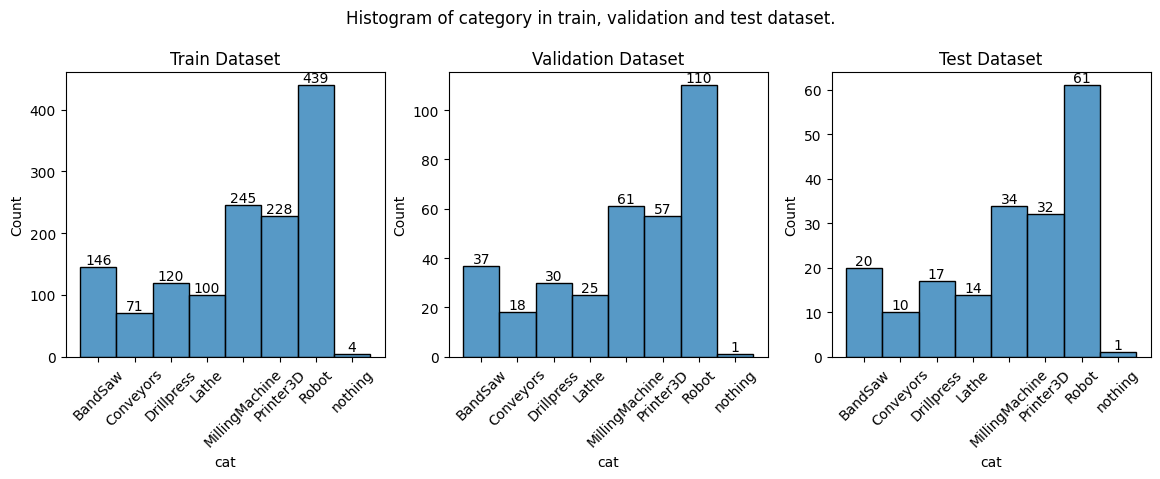

In [ ]:
data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=yaml.SafeLoader)
cat_names = data["names"] + ["nothing"]
fig, axe = plt.subplots(1, 3, figsize=(14, 3.7))
fig.suptitle("Histogram of category in train, validation and test dataset.", y=1.05)
plothist(axe[0], split_dataset["y_train"], cat_names, title="Train Dataset")
plothist(axe[1], split_dataset["y_val"], cat_names, title="Validation Dataset")
plothist(axe[2], split_dataset["y_test"], cat_names, title="Test Dataset")
plt.show()


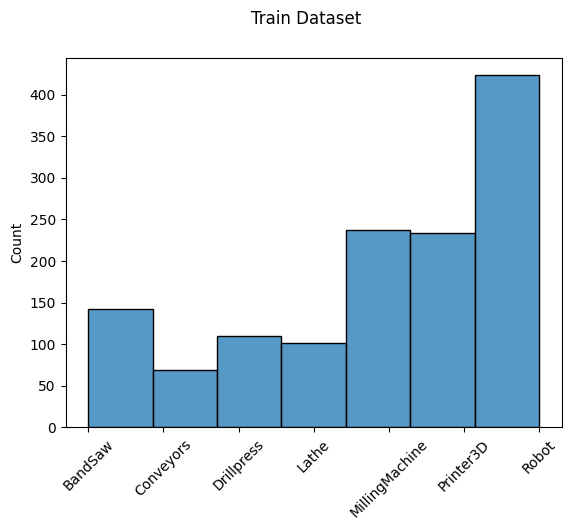

In [8]:
path = "machine_detection2-1/train/labels/"

a_list = []
a_list2 = {}
for filepath in Path(path).iterdir():
    a_arr = np.genfromtxt(filepath, delimiter=" ")
    if len(a_arr.shape) == 1:
        a_arr = a_arr.reshape(1,-1)
    a_list2[filepath.stem] = a_arr[:,0]
    for item in a_arr[:,0]:
        a_list.append(item)

classes = data["names"]
tt_classes = len(classes)
fig, axe = plt.subplots()
fig.suptitle("Train Dataset")
sns.histplot(a_list, ax=axe, bins=tt_classes)
axe.set_xticks(range(0, tt_classes))
axe.set_xticklabels(classes, rotation=45)
plt.show()


In [10]:
a = np.array(a_list)
unique, counts = np.unique(a, return_counts=True)
target = max(counts)
a = dict(zip(unique, target-counts))
a

{0.0: 281, 1.0: 354, 2.0: 313, 3.0: 322, 4.0: 186, 5.0: 190, 6.0: 0}

In [6]:
from detection.utils.augmentation import flip_horizontal, crop
import random


In [13]:
label_id = 0
img_names = [k for k, v in a_list2.items() if label_id in v]
img_names_random = random.choices(img_names, k=1)
print(img_names_random)
for i in img_names_random:
    img = cv2.imread(f"machine_detection2-1/train/images/{i}.JPG")
    targets = np.genfromtxt(f"machine_detection2-1/train/labels/{i}.txt", delimiter=" ")
    targets = format_yolov5(targets, img)
    img, targets = flip_horizontal(img, targets)
    cv2.imwrite(f"detection/versions/version1/images/{i}.JPG", img)
    np.savetxt(f"detection/versions/version1/labels/{i}.txt", targets, fmt="%.8f", delimiter=",")

['IMG_0790_JPG.rf.6ed14c6e5d0d0e45311f858638d90f69']


In [2]:
data = yaml.load(open("detection/dataset/data_whole.yaml"), Loader=SafeLoader)
img = cv2.imread("detection/versions/version1/images/IMG_0790_JPG.rf.6ed14c6e5d0d0e45311f858638d90f69.JPG")
targets = np.genfromtxt("detection/versions/version1/labels/IMG_0790_JPG.rf.6ed14c6e5d0d0e45311f858638d90f69.txt", delimiter=",")
# targets = format_yolov5(targets, img)
print(targets)

img_anno = drawBox(img, targets, data["names"])
cv2.imwrite("results/IMG_0790_anno.JPG", img_anno)

[[ 95.75 160.   420.25 640.     4.  ]
 [106.75 205.   178.25 323.     2.  ]
 [ 34.   292.75 134.   449.25   0.  ]]
409600
0.1024
0.512
0.512


True